First of all, we include all the necessary libraries and processes we are going to use through out our project.
We set the learning rate, and the image's height and weight as variables to be uses through our entire code.

Additionally, we create a function 'load_image_into_numpy_array' , it takes an image as input and converts it into a NumPy array.

In [1]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg


#defining the variables

LEARNING_RATE = 0.0001
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256



# The function essentially takes an image,
# ensures it's in RGB format
# retrieves its size
# converts the pixel values into a NumPy array with the appropriate shape
# and then returns the array.

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

print("Great! Let's get started.")

Great! Let's get started.


In [2]:
finding = "atelectasis"
finding = finding.capitalize()

In [3]:
df = pd.read_csv("D:\projects\ChestXrays-InceptionV3\medical\labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [4]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)

if n == 0:
  print("No studies found! Maybe check your spelling?")
  assert (n > 0)

In [5]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
n = len(positives)
TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

144 36


In [6]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

In [7]:
rootdir = "D:/projects/ChestXrays-InceptionV3/medical/images/"
os.makedirs(rootdir+finding+"/test/positive",  exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [8]:
# copy images to new directories for training purposes
for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[TRAIN_N:n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("Done moving "+str(n*2)+" images to positive and negative folders.")

Done moving 360 images to positive and negative folders.


In [9]:
# load images into memory for visualization
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

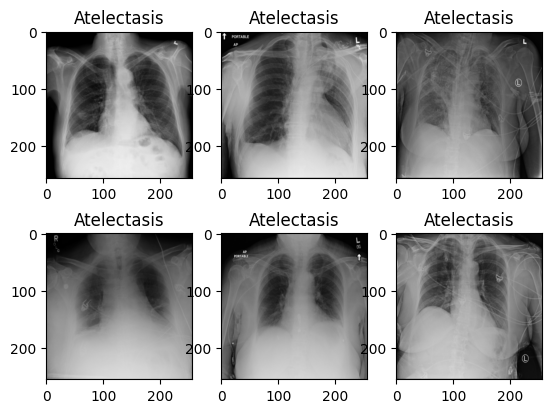

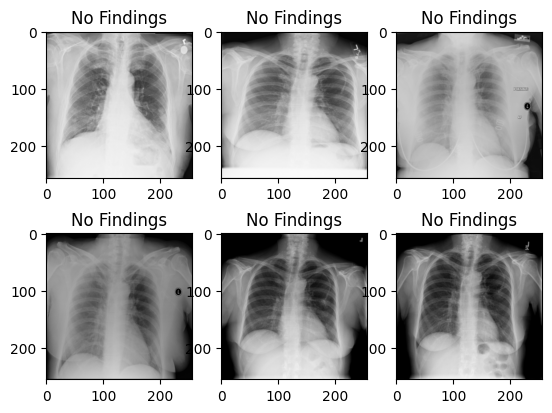

In [10]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(negative_imgs[idx])
plt.show()

In [11]:
pre_trained_model = InceptionV3(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top=False)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)                        # Flatten the output layer to 1 dimension
x = layers.Dense(1024, activation='relu')(x)             # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.2)(x)                               # Add a dropout rate of 0.2
x = layers.Dense(1, activation='sigmoid')(x)             # Add a final sigmoid layer for classification

model = Model(pre_trained_model.input, x)                # Configure and compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print("Done compiling the model!")

Done compiling the model!


In [12]:
# Define our example directories and files
base_dir = rootdir = "D:/projects/ChestXrays-InceptionV3/medical/images/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

`ImageDataGenerator` from TensorFlow's Keras API is used to perform data augmentation for training our model. Data augmentation involves applying various transformations to the training images which artificially increases the diversity of the training dataset. Helps improve the model's generalization performance

In [13]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)

# Note that the test data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

In [77]:
train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=1,
        class_mode='binary')

train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2
# print(train_steps)
print("Done funneling data!")

Found 288 images belonging to 2 classes.


Found 72 images belonging to 2 classes.
Done funneling data!


In [31]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=20,
      validation_data=test_generator,
      validation_steps=test_steps,
      verbose=2)

Epoch 1/20
288/288 - 538s - loss: 0.6216 - acc: 0.6840 - val_loss: 0.5955 - val_acc: 0.8056 - 538s/epoch - 2s/step
Epoch 2/20
288/288 - 565s - loss: 0.5455 - acc: 0.7257 - val_loss: 0.9696 - val_acc: 0.5139 - 565s/epoch - 2s/step
Epoch 3/20
288/288 - 548s - loss: 0.5527 - acc: 0.7257 - val_loss: 0.8661 - val_acc: 0.5556 - 548s/epoch - 2s/step
Epoch 4/20
288/288 - 545s - loss: 0.5170 - acc: 0.7674 - val_loss: 0.9484 - val_acc: 0.6111 - 545s/epoch - 2s/step
Epoch 5/20
288/288 - 559s - loss: 0.5508 - acc: 0.7361 - val_loss: 1.0620 - val_acc: 0.5417 - 559s/epoch - 2s/step
Epoch 6/20
288/288 - 615s - loss: 0.5066 - acc: 0.7465 - val_loss: 0.8061 - val_acc: 0.6528 - 615s/epoch - 2s/step
Epoch 7/20
288/288 - 892s - loss: 0.4616 - acc: 0.7812 - val_loss: 0.6757 - val_acc: 0.7361 - 892s/epoch - 3s/step
Epoch 8/20
288/288 - 955s - loss: 0.4816 - acc: 0.7812 - val_loss: 0.8082 - val_acc: 0.6667 - 955s/epoch - 3s/step
Epoch 9/20
288/288 - 1049s - loss: 0.5269 - acc: 0.7361 - val_loss: 0.6054 - val

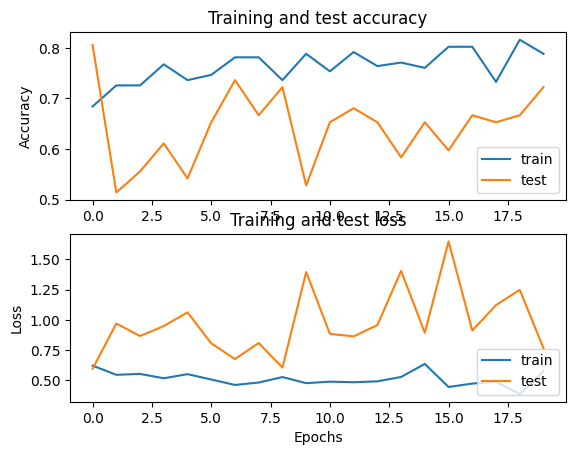

In [44]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.show()


To evaluate the performance of our model, we iterate over our images and then run the pretrained model on them. By doing this we get the confidence score for each image. As we iterate over these, we also sort the data based on the confidence score in ascending order.

In [45]:
def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  exp = np.true_divide(image_np, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  exp = np.true_divide(img, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [46]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

print("Done inference!")

1/1 [==============================] - 0s 100ms/step
Done inference!


In [48]:
df.head()

,filepath,filename,label,guess,confidence
0,D:/projects/ChestXrays-InceptionV3/medical/ima...,00029843_001.jpg,pos,pos,0.999900
1,D:/projects/ChestXrays-InceptionV3/medical/ima...,00021703_001.jpg,pos,pos,0.999349
2,D:/projects/ChestXrays-InceptionV3/medical/ima...,00008814_010.jpg,pos,pos,0.999341
3,D:/projects/ChestXrays-InceptionV3/medical/ima...,00025769_001.jpg,pos,pos,0.999265
4,D:/projects/ChestXrays-InceptionV3/medical/ima...,00007120_009.jpg,pos,pos,0.998062


Testing with a random image from the dataset

1/1 [==============================] - 0s 106ms/step


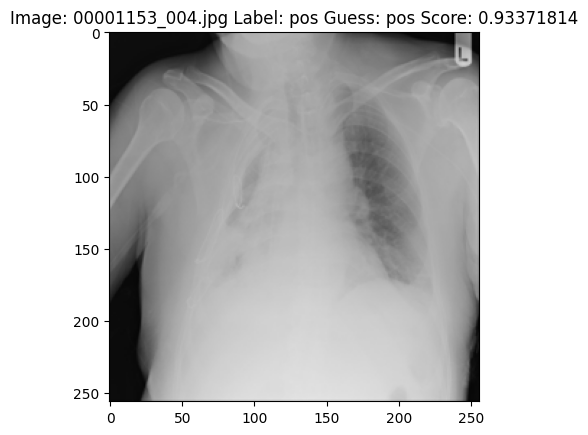

In [53]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

In [54]:
df[::5][['filename', 'label',"guess","confidence"]]

,filename,label,guess,confidence
0,00029843_001.jpg,pos,pos,0.999900
5,00013187_002.jpg,pos,pos,0.996042
10,00026920_000.jpg,pos,pos,0.992276
15,00000108_001.jpg,neg,pos,0.983924
20,00016490_011.jpg,pos,pos,0.970714
25,00025270_000.jpg,pos,pos,0.958124
30,00000118_012.jpg,neg,pos,0.904531
35,00012636_000.jpg,pos,pos,0.856925
40,00000112_001.jpg,neg,pos,0.752431
45,00000116_038.jpg,neg,pos,0.685048


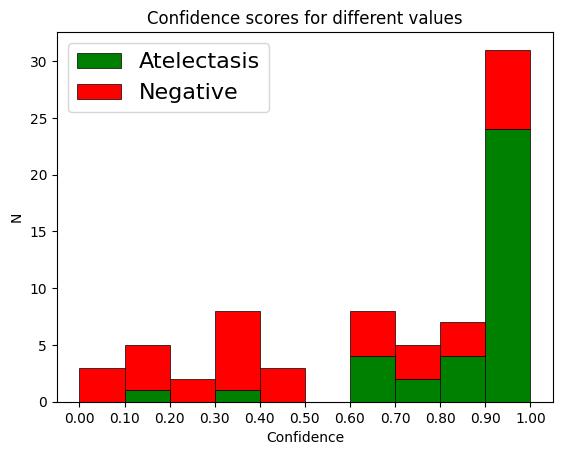

In [56]:
from matplotlib.ticker import FormatStrFormatter
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]
fig, ax = plt.subplots()
n, bins, patches = plt.hist([pos,neg], np.arange(0.0, 1.1, 0.1).tolist(), edgecolor='black', linewidth=0.5, density=False, histtype='bar', stacked=True, color=['green', 'red'], label=[finding, 'Negative'])
plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for different values')
plt.legend(loc="upper left", fontsize=16)
plt.show()

Now, creating a histogram of confidence scores based on different conditions (True Positive, False Positive, True Negative, False Negative) and display sensitivity, specificity, and other statistics for a given cutoff value.

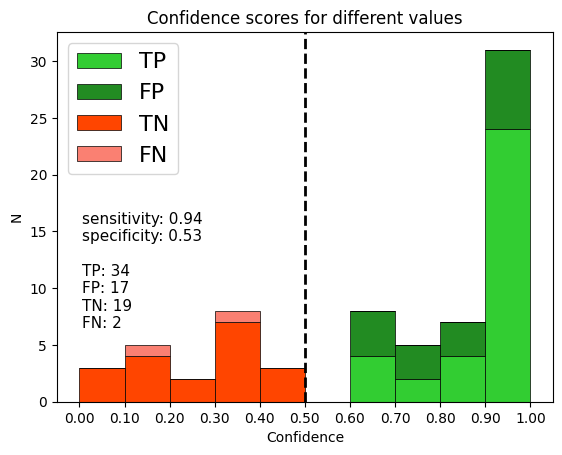

In [76]:
def create_with_cutoff(cutoff):
  __, ax = plt.subplots()
  TP = df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"]
  FP = df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"]
  FN = df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"]
  TN = df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"]
  plt.hist([TP,FP,TN,FN], np.arange(0.0, 1.1, 0.1).tolist(), \
           edgecolor='black', linewidth=0.5, density=False, histtype='bar', \
           stacked=True, color=['limegreen','forestgreen','orangered','salmon'], \
           label=['TP','FP','TN','FN'])
  plt.xlabel('Confidence')
  plt.ylabel('N')
  plt.xticks(bins)
  ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.title('Confidence scores for different values')
  plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
  plt.legend(loc="upper left", fontsize=16)
  sens = round(len(TP)/(len(TP)+len(FN)),2)
  spec = round(len(TN)/(len(TN)+len(FP)),2)
  stats = "sensitivity: "+str(sens)+"\n"+"specificity: "+str(spec)+"\n\n"+"TP: "+str(len(TP))+"\n"+"FP: "+str(len(FP))+"\n"+"TN: "+str(len(TN))+"\n"+"FN: "+str(len(FN))
  plt.text(0.05, 0.2, stats, fontsize=11, transform=ax.transAxes)
  plt.show()

create_with_cutoff(cutoff=0.5)

ROC curve for Evaluating performance of the model.
The ROC (Receiver Operating Characteristic) curve is a graphical representation of a binary classification model's performance across different classification thresholds. The area under the ROC curve (AUC) quantifies the overall performance of the model. Here's what different AUC values generally indicate:
•	AUC = 0.5 (Random Classifier): If the AUC is 0.5, it suggests that the model's performance is no better than random chance. 
•	0.5 < AUC < 1.0 (Better than Random): As the AUC increases beyond 0.5, it indicates that the model is better than random chance. 
•	AUC = 1.0 (Perfect Classifier): A perfect classifier would have an AUC of 1.0, indicating that it achieves 100% true positive rate (sensitivity) with 0% false positive rate (1-specificity) across all thresholds. However, in practice, achieving a perfect AUC is rare.


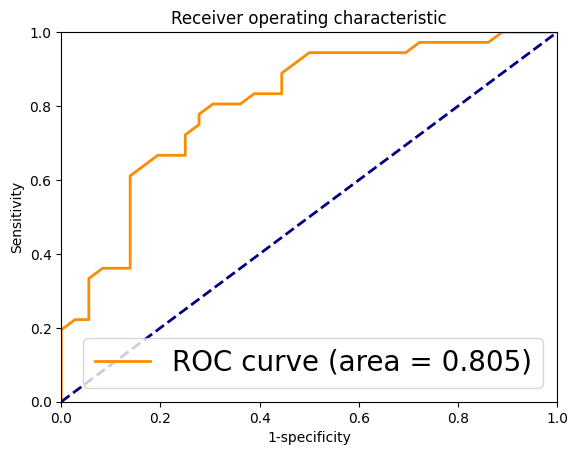

In [75]:
def create_auc_curve(classifications):
  squares = {}
  for x in classifications:
    conf = x[4]
    TP, FP, TN, FN = 0, 0, 0, 0
    for row in classifications:
      assert (row[2] == "neg" or row[2] == "pos")
      if row[2] == "neg":
        if float(row[4]) < conf: TN += 1
        else: FP += 1
      else:
        if float(row[4]) > conf: TP += 1
        else: FN += 1
    squares[conf] = [TP, FP, TN, FN]
  # now we have a list of stuff: convert to
  sens_spec = {}
  for entry in squares:
    sens = squares[entry][0] / float(squares[entry][0] + squares[entry][3])
    spec = squares[entry][2] / float(squares[entry][2] + squares[entry][1])
    sens_spec[entry] = (1-spec, sens)
  return squares, sens_spec

squares, sens_spec = create_auc_curve(sorted_results)
x = []
y = []
for point in sens_spec.keys():
  x.append(sens_spec[point][0])
  y.append(sens_spec[point][1])

auc = sklearn.metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.show()